In [1]:
import torch
import matplotlib.pyplot as plt
import math

from renderer import project_gaussians, rasterize_gaussians, get_bounding_boxes, tile_gaussians, g
from utils import ellipse_ndim, plot_tile_map

from matplotlib.patches import Polygon

import numpy as np

### Data

In [2]:
N = 10

mu = (torch.rand((N,3)) - 0.5) * 4.
scale = torch.rand((N,3)) * 0.2
quat = torch.rand((N, 4))
col = torch.rand((N, 3))
opc = torch.rand((N,))

### Projection

In [3]:
# Output Image Width and Height
W = 1920
H = 1072 

In [4]:
fov_x = math.pi / 2.0 # Angle of the camera frustum 90°
focal = 0.5 * float(W) / math.tan(0.5 * fov_x) # Distance to Image Plane

viewmat = torch.eye(4)
viewmat[:3,3] = torch.tensor([0,0,-4])

In [5]:
(
    mu_,
    cov_,
    z
) = project_gaussians(
    means3d=mu,
    scales=scale,
    quats=quat,
    colors=col,
    viewmat=viewmat,
    fx=focal,
    fy=focal,
    cx=W/2,
    cy=H/2,
    img_height=H,
    img_width=W
)

### Rendering

In [6]:
out_img = rasterize_gaussians(
    xys=mu_,
    depths=z,
    covs=cov_,
    conics=None,
    num_tiles_hit=None,
    colors=col,
    opacity=opc,
    img_height=H,
    img_width=W,
    block_width=None,
    background=None,
    return_alpha=None
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


### Tiling

In [7]:
rot_box = get_bounding_boxes(mu_, cov_)

In [8]:
W, H

(1920, 1072)

In [9]:
tile_size = 16

In [10]:
tile_map = tile_gaussians(mu_, cov_, tile_size, H, W)

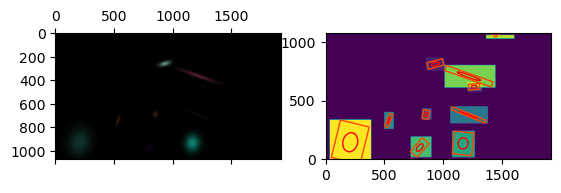

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(out_img)

plot_tile_map(tile_map, H, W, ax=ax2)

ellipse_ndim(mu_, cov_, ax2, edgecolor='red')
ax2.set_aspect('equal', adjustable='box')

ax2.set_xlim([0,W])
ax2.set_ylim([0,H])

for box in rot_box:
    ax2.add_patch(Polygon(box, fc='none', ec='orangered'))

In [12]:
def rasterize_gaussians_patch(
        xys,
        depths,
        covs,
        colors,
        opacity,
        x_range, 
        y_range,
    ):
    x_min, x_max = x_range
    y_min, y_max = y_range

    w = x_max - x_min
    h = y_max - y_min

    x, y = torch.meshgrid(torch.linspace(x_min, x_max, w),torch.linspace(y_min, y_max, h), indexing='xy')
    x = x.reshape(1,-1); y = y.reshape(1, -1)

    # _, ind = torch.sort(depths)
    # xys, covs, colors = xys[ind], covs[ind], colors[ind]

    pixels_xy = torch.cat((x.reshape(1,-1),y.reshape(1,-1)), dim=0)

    out_img = torch.zeros(h, w, 3)
    cum_alphas = torch.ones(1, h, w)
    for m, S, c, o in zip(xys, covs, colors, opacity):
        alpha = g(pixels_xy, m, S).view(1, h, w) * o
        out_img += (alpha * c.view(3,1,1) * cum_alphas).permute((1,2,0)).flip(dims=(0,))
        cum_alphas *= (1 - alpha)

    return out_img

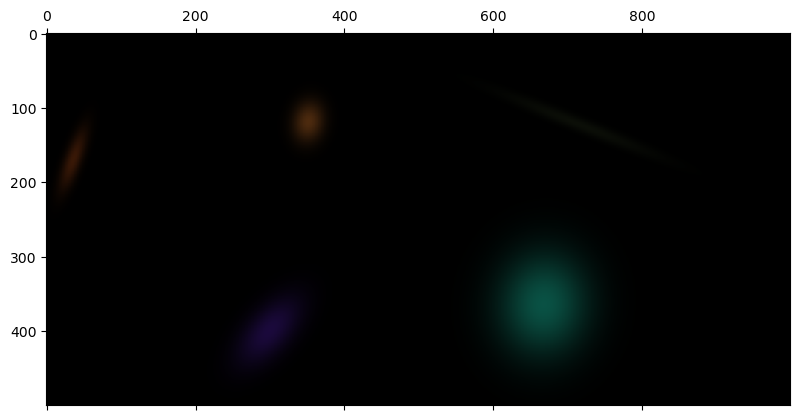

In [15]:
plt.matshow(rasterize_gaussians_patch(mu_, z, cov_, col, opc, 
                          (500, 1_500), (0, 500)))